In [54]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import requests # library to handle requests
from bs4 import BeautifulSoup



In [15]:
conda install -c conda-forge geopy --yes 

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [21]:
pip install geocoder

     |████████████████████████████████| 98 kB 1.3 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [55]:
berlin_postal = pd.read_csv('berlin_postalcodes.csv', engine = 'python')
berlin_postal.head()


,Postal Code,Borough
0,10115,Berlin-Mitte
1,10117,Berlin-Mitte
2,10119,Berlin-Mitte
3,10178,Berlin-Mitte
4,10179,Berlin-Mitte


In [56]:
berlin_postal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113 entries, 0 to 112
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Postal Code  113 non-null    int64 
 1   Borough      113 non-null    object
dtypes: int64(1), object(1)
memory usage: 1.9+ KB


In [57]:
berlin_coord = pd.read_csv('berlin_coords.csv', engine = 'python')
berlin_coord.head()

,Postal Code,Location
0,10115,52.532/13.385
1,10117,52.517/13.387
2,10119,52.53/13.405
3,10178,52.521/13.41
4,10179,52.512/13.416


In [58]:
berlin_coord.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113 entries, 0 to 112
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Postal Code  113 non-null    int64 
 1   Location     113 non-null    object
dtypes: int64(1), object(1)
memory usage: 1.9+ KB


In [59]:
berlin_coord2 ={}
berlin_coord2['Latitude'] = berlin_coord['Location'].str.split('/',expand=True)[0]
berlin_coord2['Longitude'] = berlin_coord['Location'].str.split('/',expand=True)[1]
berlin_coord2

{'Latitude': 0      52.532
 1      52.517
 2       52.53
 3      52.521
 4      52.512
         ...  
 108     52.42
 109    52.437
 110    52.418
 111    52.421
 112     52.45
 Name: 0, Length: 113, dtype: object,
 'Longitude': 0      13.385
 1      13.387
 2      13.405
 3       13.41
 4      13.416
         ...  
 108    13.144
 109    13.239
 110    13.254
 111    13.277
 112    13.257
 Name: 1, Length: 113, dtype: object}

In [60]:
berlin_coord['Latitude'] = berlin_coord2['Latitude'] 
berlin_coord['Longitude'] = berlin_coord2['Longitude']


berlin_coord

,Postal Code,Location,Latitude,Longitude
0,10115,52.532/13.385,52.532,13.385
1,10117,52.517/13.387,52.517,13.387
2,10119,52.53/13.405,52.53,13.405
3,10178,52.521/13.41,52.521,13.41
4,10179,52.512/13.416,52.512,13.416
...,...,...,...,...
108,14109,52.42/13.144,52.42,13.144
109,14163,52.437/13.239,52.437,13.239
110,14165,52.418/13.254,52.418,13.254
111,14167,52.421/13.277,52.421,13.277


In [62]:
berlin_data = pd.merge(berlin_postal, berlin_coord, on='Postal Code')

berlin_data

,Postal Code,Borough,Location,Latitude,Longitude
0,10115,Berlin-Mitte,52.532/13.385,52.532,13.385
1,10117,Berlin-Mitte,52.517/13.387,52.517,13.387
2,10119,Berlin-Mitte,52.53/13.405,52.53,13.405
3,10178,Berlin-Mitte,52.521/13.41,52.521,13.41
4,10179,Berlin-Mitte,52.512/13.416,52.512,13.416
...,...,...,...,...,...
108,14109,Wannsee,52.42/13.144,52.42,13.144
109,14163,Zehlendorf,52.437/13.239,52.437,13.239
110,14165,Zehlendorf,52.418/13.254,52.418,13.254
111,14167,Zehlendorf,52.421/13.277,52.421,13.277


In [63]:
berlin_data.drop('Location' , inplace = True, axis = 1)
berlin_data.head()

,Postal Code,Borough,Latitude,Longitude
0,10115,Berlin-Mitte,52.532,13.385
1,10117,Berlin-Mitte,52.517,13.387
2,10119,Berlin-Mitte,52.53,13.405
3,10178,Berlin-Mitte,52.521,13.41
4,10179,Berlin-Mitte,52.512,13.416


In [64]:
# should be hidden for security reasons
CLIENT_ID = '1L12G2AAK0TJBMUF25T1CFBW5DY5H351IWSGVQBWFWPRWKT4'
CLIENT_SECRET = 'OAZIAAPBXPARMRJRGJS3H00SGUC33VRG00V5EKUL5ZTTMTDA'
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

In [65]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [66]:
berlin_venues = getNearbyVenues(names=berlin_data['Borough'],
                                   latitudes=berlin_data['Latitude'],
                                   longitudes=berlin_data['Longitude']
                                  )

Berlin-Mitte
Berlin-Mitte
Berlin-Mitte
Berlin-Mitte
Berlin-Mitte
Friedrichshain
Friedrichshain
Friedrichshain
Friedrichshain
Lichtenberg
Lichtenberg
Prenzlauer Berg
Prenzlauer Berg
Prenzlauer Berg
Prenzlauer Berg
Prenzlauer Berg
Prenzlauer Berg
Tiergarten
Tiergarten
Tiergarten
Tiergarten
Tiergarten
Charlottenburg
Charlottenburg
Charlottenburg
Charlottenburg
Charlottenburg
Charlottenburg
Charlottenburg
Wilmersdorf
Wilmersdorf
Wilmersdorf
Wilmersdorf
Wilmersdorf
Wilmersdorf
Tempelhof
Tempelhof
Tempelhof
Tempelhof
Tempelhof
Schöneberg
Schöneberg
Schöneberg
Schöneberg
Kreuzberg
Kreuzberg
Kreuzberg
Kreuzberg
Kreuzberg
Kreuzberg
Kreuzberg
Neukölln
Neukölln
Neukölln
Neukölln
Neukölln
Neukölln
Neukölln
Neukölln
Neukölln
Steglitz
Steglitz
Steglitz
Steglitz
Steglitz
Steglitz
Lichterfelde
Lichterfelde
Lichterfelde
Lichterfelde
Lankwitz
Lankwitz
Marienfelde
Marienfelde
Lichtenrade
Lichtenrade
Lichtenrade
Adlershof
Adlershof
Köpenick
Köpenick
Köpenick
Köpenick
Marzahn 
Marzahn 
Marzahn 
Marzahn 
Ma

In [67]:
print(berlin_venues.shape)
berlin_venues.head()

(3189, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Berlin-Mitte,52.532,13.385,Hotel i31,52.531107,13.384270,Hotel
1,Berlin-Mitte,52.532,13.385,Oslo Kaffebar,52.531029,13.386889,Coffee Shop
2,Berlin-Mitte,52.532,13.385,REWE,52.531612,13.388092,Supermarket
3,Berlin-Mitte,52.532,13.385,Kunstfabrik Schlot,52.530325,13.385230,Jazz Club
4,Berlin-Mitte,52.532,13.385,Titanic Chaussee Berlin,52.532215,13.381012,Hotel


In [19]:
berlin_venues.groupby('Neighborhood').count() 
#we can see that the most venues are in Neukölln, Kreuzberg, Berlin-Mitte and Charlottenburg.

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Adlershof,20,20,20,20,20,20
Berlin-Mitte,342,342,342,342,342,342
Charlottenburg,317,317,317,317,317,317
Friedrichshain,171,171,171,171,171,171
Kreuzberg,363,363,363,363,363,363
Köpenick,14,14,14,14,14,14
Lankwitz,18,18,18,18,18,18
Lichtenberg,43,43,43,43,43,43
Lichtenrade,11,11,11,11,11,11


In [68]:
berlin_venues.groupby('Venue Category').get_group('Bar')


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
145,Berlin-Mitte,52.53,13.405,Lass uns Freunde bleiben,52.533114,13.407183,Bar
181,Berlin-Mitte,52.53,13.405,Ick koof mir Dave Lombardo wenn ick reich bin,52.533909,13.403352,Bar
195,Berlin-Mitte,52.53,13.405,Schurkenkeller,52.532644,13.410348,Bar
200,Berlin-Mitte,52.53,13.405,8mm Bar,52.531117,13.411932,Bar
204,Berlin-Mitte,52.53,13.405,Suzie Mambo,52.533475,13.402381,Bar
...,...,...,...,...,...,...,...
3002,Wedding,52.549,13.365,Jatz,52.550327,13.368970,Bar
3006,Wedding,52.549,13.365,WG Bar,52.549445,13.362061,Bar
3027,Wedding,52.558,13.347,Lale,52.554242,13.345153,Bar
3092,Wedding,52.55,13.383,Studio8,52.551925,13.386392,Bar


In [69]:
berlin_venues.groupby('Venue Category').get_group('Plaza')



,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
78,Berlin-Mitte,52.517,13.387,Bebelplatz,52.516530,13.393847,Plaza
155,Berlin-Mitte,52.53,13.405,Rosenthaler Platz,52.529735,13.401209,Plaza
177,Berlin-Mitte,52.53,13.405,Zionskirchplatz,52.534257,13.404267,Plaza
202,Berlin-Mitte,52.53,13.405,Teutoburger Platz,52.532018,13.408813,Plaza
232,Berlin-Mitte,52.521,13.41,Alexanderplatz,52.521698,13.413105,Plaza
305,Berlin-Mitte,52.521,13.41,Molkenmarkt,52.516665,13.409951,Plaza
356,Friedrichshain,52.512,13.439,Franz-Mehring-Platz,52.513109,13.439685,Plaza
694,Prenzlauer Berg,52.538,13.411,Kollwitzplatz,52.536236,13.417045,Plaza
755,Prenzlauer Berg,52.545,13.413,Helmholtzplatz,52.543086,13.418770,Plaza
1013,Charlottenburg,52.518,13.32,Alt-Lietzow Platz,52.516815,13.314437,Plaza


In [70]:
# one hot encoding
berlin_onehot = pd.get_dummies(berlin_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
berlin_onehot['Neighborhood'] = berlin_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [berlin_onehot.columns[-1]] + list(berlin_onehot.columns[:-1])
berlin_onehot = berlin_onehot[fixed_columns]

berlin_onehot.head()

,Neighborhood,ATM,Adult Boutique,African Restaurant,American Restaurant,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,...,Warehouse Store,Watch Shop,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo Exhibit
0,Berlin-Mitte,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Berlin-Mitte,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Berlin-Mitte,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Berlin-Mitte,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Berlin-Mitte,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [71]:
berlin_onehot.shape

(3189, 319)

In [26]:
berlin_grouped = berlin_onehot.groupby('Neighborhood').mean().reset_index()
berlin_grouped

,Neighborhood,Adult Boutique,African Restaurant,American Restaurant,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,...,Warehouse Store,Watch Shop,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo Exhibit
0,Adlershof,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Berlin-Mitte,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005848,0.005848,...,0.000000,0.000000,0.000000,0.000000,0.011696,0.002924,0.000000,0.000000,0.000000,0.000000
2,Charlottenburg,0.000000,0.000000,0.000000,0.003155,0.000000,0.000000,0.000000,0.003155,0.009464,...,0.003155,0.000000,0.000000,0.003155,0.000000,0.006309,0.000000,0.000000,0.003155,0.000000
3,Friedrichshain,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.005848,0.000000,0.000000,0.000000,0.000000
4,Kreuzberg,0.000000,0.011019,0.000000,0.000000,0.000000,0.000000,0.000000,0.005510,0.002755,...,0.000000,0.000000,0.011019,0.002755,0.008264,0.008264,0.000000,0.000000,0.002755,0.002755
5,Köpenick,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,Lankwitz,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,Lichtenberg,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.023256,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.023256
8,Lichtenrade,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,Lichterfelde,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.031250,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [72]:
berlin_grouped.shape

(26, 328)

In [73]:
#let's write a function to sort the venues in descending order.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [74]:
#let's create the new dataframe and display the top 10 venues for each neighborhood.
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = berlin_grouped['Neighborhood']

for ind in np.arange(berlin_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(berlin_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adlershof,Supermarket,Greek Restaurant,Convenience Store,Bus Stop,Soccer Field,Organic Grocery,Tram Station,Trattoria/Osteria,Taverna,Drugstore
1,Berlin-Mitte,Hotel,Coffee Shop,Italian Restaurant,Café,Bakery,Nightclub,Restaurant,Ice Cream Shop,Vietnamese Restaurant,German Restaurant
2,Charlottenburg,Italian Restaurant,Café,Hotel,Bakery,Coffee Shop,Supermarket,Vietnamese Restaurant,Asian Restaurant,Gourmet Shop,German Restaurant
3,Friedrichshain,Bar,Hotel,Bakery,Nightclub,Café,Pizza Place,Supermarket,Vietnamese Restaurant,Italian Restaurant,Drugstore
4,Kreuzberg,Café,Italian Restaurant,Coffee Shop,Bar,Ice Cream Shop,Pizza Place,Bakery,Turkish Restaurant,Vietnamese Restaurant,Cocktail Bar


In [75]:
# import k-means from clustering stage
from sklearn.cluster import KMeans
# set number of clusters
kclusters = 5

berlin_grouped_clustering = berlin_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(berlin_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_ ##[0:10] 

array([0, 4, 4, 4, 4, 2, 0, 0, 3, 0, 3, 0, 4, 0, 4, 0, 4, 4, 4, 4, 1, 4,
       0, 4, 4, 4], dtype=int32)

In [76]:
# add clustering labels
neighborhoods_venues_sorted['Cluster Labels'] = kmeans.labels_

In [77]:
berlin_data.rename(columns={'Borough':'Neighborhood'}, inplace=True)

berlin_data

,Postal Code,Neighborhood,Latitude,Longitude
0,10115,Berlin-Mitte,52.532,13.385
1,10117,Berlin-Mitte,52.517,13.387
2,10119,Berlin-Mitte,52.53,13.405
3,10178,Berlin-Mitte,52.521,13.41
4,10179,Berlin-Mitte,52.512,13.416
...,...,...,...,...
108,14109,Wannsee,52.42,13.144
109,14163,Zehlendorf,52.437,13.239
110,14165,Zehlendorf,52.418,13.254
111,14167,Zehlendorf,52.421,13.277


In [78]:
berlin_merged = berlin_data

# merge berlin_grouped with berlin_data to add latitude/longitude for each neighborhood
berlin_merged = berlin_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

berlin_merged.head() # check the last columns!
berlin_merged=berlin_merged.dropna()

In [79]:
import folium # map rendering library
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
from geopy.geocoders import Nominatim 


In [80]:
address = 'Berlin'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Berlin are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Berlin are 52.5170365, 13.3888599.


In [81]:
berlin_merged['Latitude'] = berlin_merged['Latitude'].astype('float64')
berlin_merged['Longitude'] = berlin_merged['Longitude'].astype('float64')
berlin_merged.dtypes


Postal Code                 int64
Neighborhood               object
Latitude                  float64
Longitude                 float64
1st Most Common Venue      object
2nd Most Common Venue      object
3rd Most Common Venue      object
4th Most Common Venue      object
5th Most Common Venue      object
6th Most Common Venue      object
7th Most Common Venue      object
8th Most Common Venue      object
9th Most Common Venue      object
10th Most Common Venue     object
Cluster Labels              int32
dtype: object

In [102]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(berlin_merged['Latitude'], berlin_merged['Longitude'], berlin_merged['Neighborhood'], berlin_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

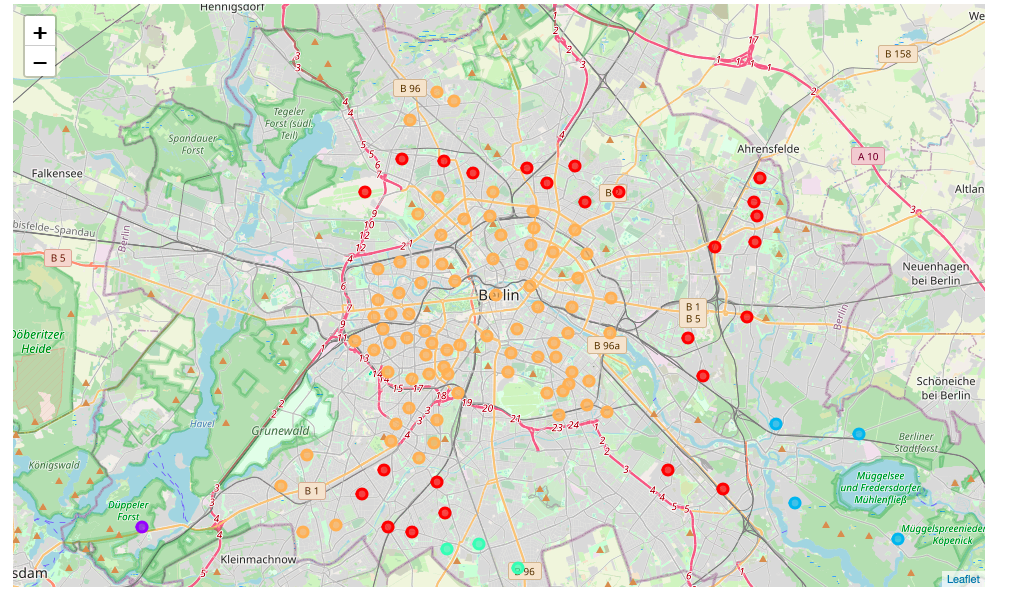

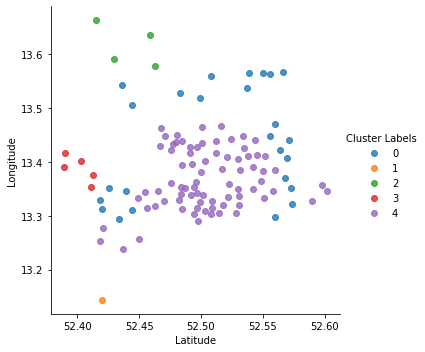

In [45]:
sns.lmplot(data=berlin_merged, x='Latitude', y='Longitude', hue='Cluster Labels', 
                   fit_reg=False, legend=True, legend_out=True)

## Cluster 1

In [83]:
berlin_merged.loc[berlin_merged['Cluster Labels'] == 0, berlin_merged.columns[[1] + list(range(4, berlin_merged.shape[1]))]]




,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
9,Lichtenberg,Supermarket,Drugstore,Tram Station,Post Office,Pharmacy,Restaurant,Zoo Exhibit,Greek Restaurant,Gift Shop,German Restaurant,0
10,Lichtenberg,Supermarket,Drugstore,Tram Station,Post Office,Pharmacy,Restaurant,Zoo Exhibit,Greek Restaurant,Gift Shop,German Restaurant,0
66,Lichterfelde,Supermarket,Light Rail Station,Plaza,Park,Chinese Restaurant,Fast Food Restaurant,Italian Restaurant,Clothing Store,Photography Studio,Bus Stop,0
67,Lichterfelde,Supermarket,Light Rail Station,Plaza,Park,Chinese Restaurant,Fast Food Restaurant,Italian Restaurant,Clothing Store,Photography Studio,Bus Stop,0
68,Lichterfelde,Supermarket,Light Rail Station,Plaza,Park,Chinese Restaurant,Fast Food Restaurant,Italian Restaurant,Clothing Store,Photography Studio,Bus Stop,0
69,Lichterfelde,Supermarket,Light Rail Station,Plaza,Park,Chinese Restaurant,Fast Food Restaurant,Italian Restaurant,Clothing Store,Photography Studio,Bus Stop,0
70,Lankwitz,Drugstore,Bus Stop,Bakery,Italian Restaurant,Light Rail Station,Pool,Skating Rink,Spa,Supermarket,Movie Theater,0
71,Lankwitz,Drugstore,Bus Stop,Bakery,Italian Restaurant,Light Rail Station,Pool,Skating Rink,Spa,Supermarket,Movie Theater,0
77,Adlershof,Supermarket,Greek Restaurant,Convenience Store,Bus Stop,Soccer Field,Organic Grocery,Tram Station,Trattoria/Osteria,Taverna,Drugstore,0
78,Adlershof,Supermarket,Greek Restaurant,Convenience Store,Bus Stop,Soccer Field,Organic Grocery,Tram Station,Trattoria/Osteria,Taverna,Drugstore,0


## Cluster 2

In [84]:
berlin_merged.loc[berlin_merged['Cluster Labels'] == 1, berlin_merged.columns[[1] + list(range(4, berlin_merged.shape[1]))]]



,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
108,Wannsee,Italian Restaurant,Farmers Market,Organic Grocery,Art Gallery,Bus Stop,Zoo Exhibit,Food,Falafel Restaurant,Fast Food Restaurant,Fish Market,1


## Cluster 3

In [85]:
berlin_merged.loc[berlin_merged['Cluster Labels'] == 2, berlin_merged.columns[[1] + list(range(4, berlin_merged.shape[1]))]]



,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
79,Köpenick,American Restaurant,Soccer Field,Gastropub,German Restaurant,Light Rail Station,Italian Restaurant,Supermarket,Playground,Tram Station,IT Services,2
80,Köpenick,American Restaurant,Soccer Field,Gastropub,German Restaurant,Light Rail Station,Italian Restaurant,Supermarket,Playground,Tram Station,IT Services,2
81,Köpenick,American Restaurant,Soccer Field,Gastropub,German Restaurant,Light Rail Station,Italian Restaurant,Supermarket,Playground,Tram Station,IT Services,2
82,Köpenick,American Restaurant,Soccer Field,Gastropub,German Restaurant,Light Rail Station,Italian Restaurant,Supermarket,Playground,Tram Station,IT Services,2


## Cluster 4

In [86]:
berlin_merged.loc[berlin_merged['Cluster Labels'] == 3, berlin_merged.columns[[1] + list(range(4, berlin_merged.shape[1]))]]



,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
72,Marienfelde,Bus Stop,Gas Station,Supermarket,Tennis Court,Park,Arcade,Soccer Field,Diner,Fondue Restaurant,Farmers Market,3
73,Marienfelde,Bus Stop,Gas Station,Supermarket,Tennis Court,Park,Arcade,Soccer Field,Diner,Fondue Restaurant,Farmers Market,3
74,Lichtenrade,Supermarket,Bus Stop,Italian Restaurant,Mexican Restaurant,Park,Electronics Store,Light Rail Station,Tennis Court,Flower Shop,Fast Food Restaurant,3
75,Lichtenrade,Supermarket,Bus Stop,Italian Restaurant,Mexican Restaurant,Park,Electronics Store,Light Rail Station,Tennis Court,Flower Shop,Fast Food Restaurant,3
76,Lichtenrade,Supermarket,Bus Stop,Italian Restaurant,Mexican Restaurant,Park,Electronics Store,Light Rail Station,Tennis Court,Flower Shop,Fast Food Restaurant,3


## Cluster 5

In [89]:
pd.set_option('display.max_rows', 500) 

berlin_merged.loc[berlin_merged['Cluster Labels'] == 4, berlin_merged.columns[[1] + list(range(4, berlin_merged.shape[1]))]]





,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
0,Berlin-Mitte,Hotel,Coffee Shop,Italian Restaurant,Café,Bakery,Nightclub,Restaurant,Ice Cream Shop,Vietnamese Restaurant,German Restaurant,4
1,Berlin-Mitte,Hotel,Coffee Shop,Italian Restaurant,Café,Bakery,Nightclub,Restaurant,Ice Cream Shop,Vietnamese Restaurant,German Restaurant,4
2,Berlin-Mitte,Hotel,Coffee Shop,Italian Restaurant,Café,Bakery,Nightclub,Restaurant,Ice Cream Shop,Vietnamese Restaurant,German Restaurant,4
3,Berlin-Mitte,Hotel,Coffee Shop,Italian Restaurant,Café,Bakery,Nightclub,Restaurant,Ice Cream Shop,Vietnamese Restaurant,German Restaurant,4
4,Berlin-Mitte,Hotel,Coffee Shop,Italian Restaurant,Café,Bakery,Nightclub,Restaurant,Ice Cream Shop,Vietnamese Restaurant,German Restaurant,4
5,Friedrichshain,Bar,Hotel,Bakery,Nightclub,Café,Pizza Place,Supermarket,Vietnamese Restaurant,Italian Restaurant,Drugstore,4
6,Friedrichshain,Bar,Hotel,Bakery,Nightclub,Café,Pizza Place,Supermarket,Vietnamese Restaurant,Italian Restaurant,Drugstore,4
7,Friedrichshain,Bar,Hotel,Bakery,Nightclub,Café,Pizza Place,Supermarket,Vietnamese Restaurant,Italian Restaurant,Drugstore,4
8,Friedrichshain,Bar,Hotel,Bakery,Nightclub,Café,Pizza Place,Supermarket,Vietnamese Restaurant,Italian Restaurant,Drugstore,4
11,Prenzlauer Berg,Café,Bakery,Ice Cream Shop,Coffee Shop,Bar,Supermarket,Vietnamese Restaurant,Korean Restaurant,Pizza Place,Organic Grocery,4


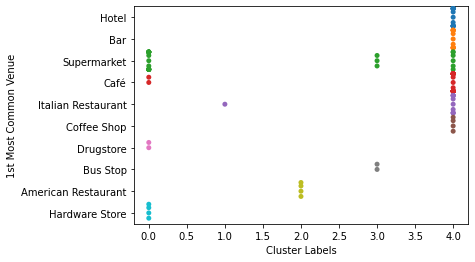

In [90]:
sns.swarmplot(berlin_merged['Cluster Labels'],berlin_merged['1st Most Common Venue'])


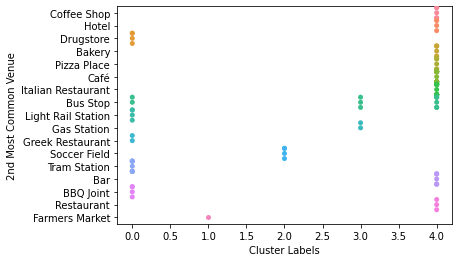

In [91]:
sns.swarmplot(berlin_merged['Cluster Labels'],berlin_merged['2nd Most Common Venue'])



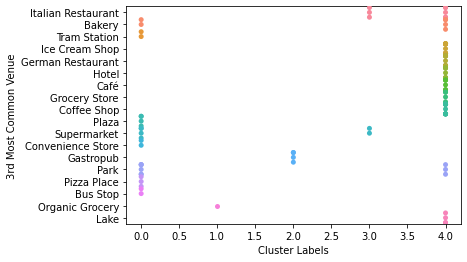

In [92]:
sns.swarmplot(berlin_merged['Cluster Labels'],berlin_merged['3rd Most Common Venue'])



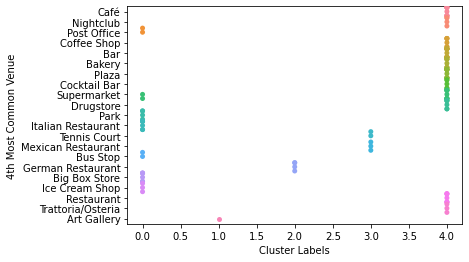

In [93]:
sns.swarmplot(berlin_merged['Cluster Labels'],berlin_merged['4th Most Common Venue'])



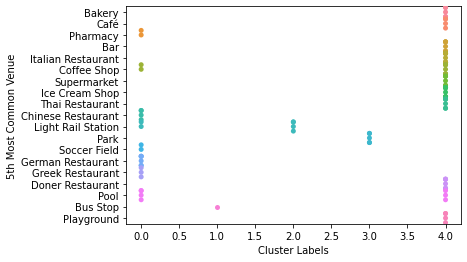

In [94]:
sns.swarmplot(berlin_merged['Cluster Labels'],berlin_merged['5th Most Common Venue'])



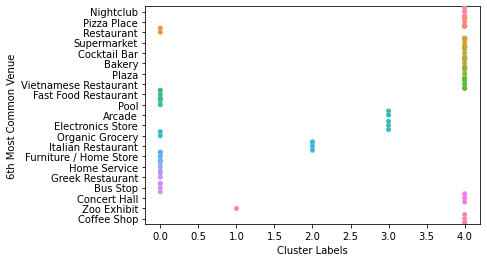

In [95]:
sns.swarmplot(berlin_merged['Cluster Labels'],berlin_merged['6th Most Common Venue'])



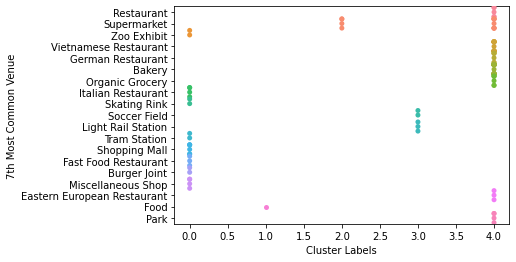

In [96]:
sns.swarmplot(berlin_merged['Cluster Labels'],berlin_merged['7th Most Common Venue'])



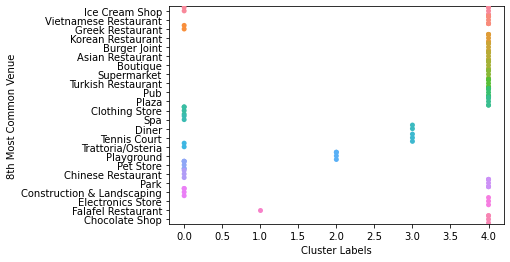

In [97]:
sns.swarmplot(berlin_merged['Cluster Labels'],berlin_merged['8th Most Common Venue'])



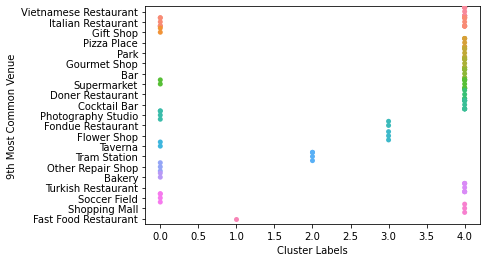

In [99]:
sns.swarmplot(berlin_merged['Cluster Labels'],berlin_merged['9th Most Common Venue'])



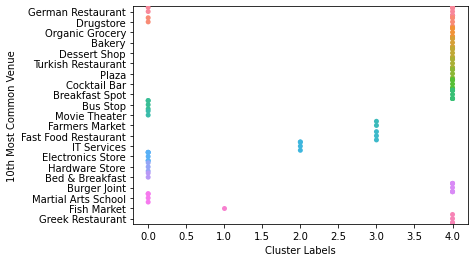

In [100]:
sns.swarmplot(berlin_merged['Cluster Labels'],berlin_merged['10th Most Common Venue'])



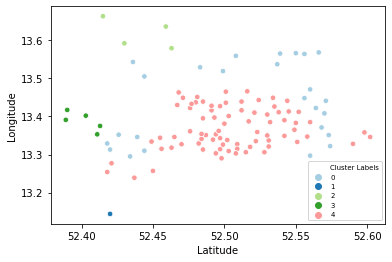

In [117]:
sns.scatterplot( x='Latitude', y='Longitude', hue='Cluster Labels',
                data=berlin_merged, palette='Paired', s=30);
plt.legend(fontsize='x-small' ,loc='lower right');